In [289]:
import json
import numpy as np
import hdbscan
from hdbscan import HDBSCAN
from hdbscan.validity import validity_index
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import plotly.express as px
import colorcet as cc
from collections import defaultdict
import warnings
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [290]:

sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha': 0.5, 's': 80, 'linewidths': 0}

def build_folder_structure(labels, titles):
    root = {"name": "Root", "type": "folder", "children": []}
    clusters = defaultdict(list)
    
    for label, title in zip(labels, titles):
        if label != -1:  # -1 is the noise label in HDBSCAN
            clusters[label].append({"name": title, "type": "bookmark"})
        else:
            root["children"].append({"name": title, "type": "bookmark"})
    
    for label, bookmarks in clusters.items():
        cluster_folder = {"name": f"Cluster {label}", "type": "folder", "children": bookmarks}
        root["children"].append(cluster_folder)
    
    return root

def print_folder_structure(folder, indent=0):
    prefix = "  " * indent
    if folder["type"] == "folder":
        print(f"{prefix}+ {folder['name']} ({len([c for c in folder['children'] if c['type'] == 'bookmark'])} bookmarks, {len([c for c in folder['children'] if c['type'] == 'folder'])} subfolders)")
        for child in folder["children"]:
            print_folder_structure(child, indent + 1)
    else:
        print(f"{prefix}- {folder['name']}")

def visualize_embeddings_plotly(embeddings_2d, labels, titles):
    df = pd.DataFrame({
        't-SNE1': embeddings_2d[:, 0],
        't-SNE2': embeddings_2d[:, 1],
        'Cluster': labels,
        'Title': titles
    })

    color_palette = cc.glasbey_dark

    fig = px.scatter(df, x='t-SNE1', y='t-SNE2', color='Cluster',
                     hover_data=['Title'], color_discrete_sequence=color_palette)

    fig.update_layout(
        title="Interactive t-SNE Visualization of Bookmark Clusters",
        plot_bgcolor='rgb(250,250,250)',
        width=1000,
        height=800,
    )

    fig.show()
    fig.write_html("bookmark_clusters_interactive.html")
    print("Interactive plot saved as 'bookmark_clusters_interactive.html'")

def visualize_embeddings_3d_plotly(embeddings_3d, labels, titles):
    df = pd.DataFrame({
        't-SNE1': embeddings_3d[:, 0],
        't-SNE2': embeddings_3d[:, 1],
        't-SNE3': embeddings_3d[:, 2],
        'Cluster': labels,
        'Title': titles
    })

    color_palette = cc.glasbey_dark

    fig = px.scatter_3d(df, x='t-SNE1', y='t-SNE2', z='t-SNE3', color='Cluster',
                        hover_data=['Title'], color_discrete_sequence=color_palette)

    fig.update_layout(
        title="Interactive 3D t-SNE Visualization of Bookmark Clusters",
        plot_bgcolor='rgb(250,250,250)',
        width=1000,
        height=800,
    )

    fig.show()

In [291]:
# Load the embedded bookmarks
with open('embedded_bookmarks.json') as f:
    data = json.load(f)

embeddings = np.array([bookmark["embedding"] for bookmark in data])

print("\nHDBSCAN Clustering:")

#scale
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)


clusterer = HDBSCAN(gen_min_span_tree=True)
clusterer.fit(embeddings_scaled)


hdbscan_labels = clusterer.labels_
hdbscan_score = validity_index(embeddings_scaled, hdbscan_labels)

titles = [bookmark["title"] for bookmark in data]
print(f"HDBSCAN Score: {hdbscan_score:.4f}")
print(f"Number of Clusters: {len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)}")

# Build and print folder structure
folder_structure = build_folder_structure(hdbscan_labels, titles)
# print("\nFolder Structure:")
# print_folder_structure(folder_structure)

embeddings_reduced = TruncatedSVD(n_components=50, random_state=42).fit_transform(embeddings)

# Perform t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_reduced)

# Visualize with Plotly
visualize_embeddings_plotly(embeddings_2d, hdbscan_labels, titles)

# Perform t-SNE for 3D visualization
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(embeddings_reduced)

# Visualize with Plotly
visualize_embeddings_3d_plotly(embeddings_3d, hdbscan_labels, titles)


HDBSCAN Clustering:
HDBSCAN Score: 0.0457
Number of Clusters: 21


Interactive plot saved as 'bookmark_clusters_interactive.html'



Minimum Spanning Tree Plot:


/Users/timothysereda/miniforge3/lib/python3.10/site-packages/hdbscan/plots.py:837: RuntimeWarning:

divide by zero encountered in divide

/Users/timothysereda/miniforge3/lib/python3.10/site-packages/matplotlib/lines.py:78: RuntimeWarning:

invalid value encountered in scalar multiply



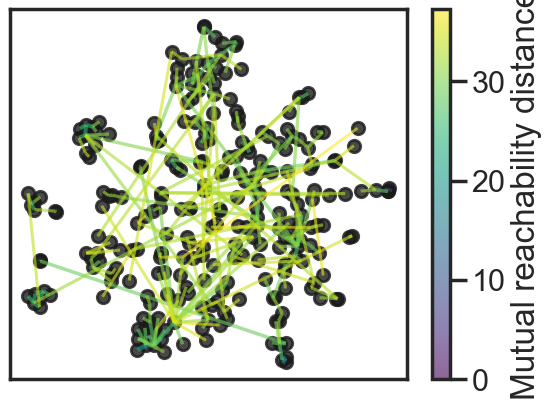

In [292]:
# Plot the minimum spanning tree
print("\nMinimum Spanning Tree Plot:")
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                              edge_alpha=0.6,
                                              node_size=80,
                                              edge_linewidth=2)
plt.show()

<Axes: ylabel='distance'>

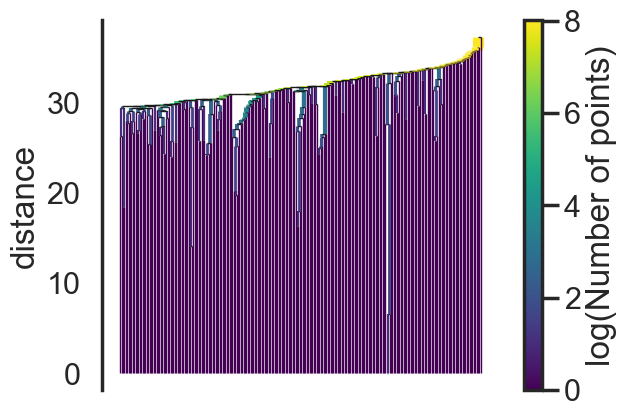

In [293]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)